### Imports:

In [118]:
import os
import numpy as np
import pandas as pd
import pm4py
import subprocess
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm import tqdm

### Data Loading:

In [14]:
file_dir = '../data/'
file_name = 'Hospital_Billing_Eventlog.xes'
download_url = 'https://data.4tu.nl/file/6af6d5f0-f44c-49be-aac8-8eaa5fe4f6fd/28b83e72-375e-4da4-8459-a8506e898edf'
# Check if file exists and download it if not

# Check if directory exists
if not os.path.exists(file_dir):
    os.system("mkdir " + file_dir)
if not os.path.exists(file_dir + file_name):
    print('Downloading file...')
    os.system(f'wget -O {file_dir + file_name + ".gz"} {download_url}')
    os.system(f'gzip -d {file_dir + file_name + ".gz"}')


In [15]:
data = pm4py.read_xes(file_dir + file_name)
event_log = pm4py.convert_to_event_log(data)

/home/mona/.bin/anaconda3/envs/pm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 100000/100000 [00:10<00:00, 9118.69it/s]


In [5]:
# Get overview over data
data

,isCancelled,diagnosis,time:timestamp,caseType,speciality,org:resource,concept:name,blocked,isClosed,flagD,...,lifecycle:transition,case:concept:name,closeCode,actRed,actOrange,flagC,msgCount,version,msgType,msgCode
0,False,A,2012-12-16 19:33:10+00:00,A,A,ResA,NEW,False,True,True,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2013-12-15 19:00:37+00:00,NaN,NaN,NaN,FIN,NaN,NaN,NaN,...,complete,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2013-12-16 03:53:38+00:00,NaN,NaN,NaN,RELEASE,NaN,NaN,NaN,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2013-12-17 12:56:29+00:00,NaN,NaN,NaN,CODE OK,NaN,NaN,NaN,...,complete,A,NaN,False,False,False,0.0,A,NaN,NaN
4,NaN,NaN,2013-12-19 03:44:31+00:00,NaN,NaN,ResB,BILLED,NaN,NaN,NaN,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451354,False,OM,2015-12-13 19:31:23+00:00,A,E,ResA,NEW,False,False,False,...,complete,AXQE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451355,False,NaN,2016-01-14 21:17:47+00:00,B,L,ResDJ,NEW,False,False,False,...,complete,BXQE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451356,True,NaN,2016-01-14 22:00:13+00:00,NaN,NaN,ResFR,DELETE,NaN,NaN,NaN,...,complete,BXQE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451357,False,LL,2016-01-11 19:40:47+00:00,A,D,ResA,NEW,False,False,False,...,complete,CXQE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
# Reduce data to relevant columns because we do not use attributes in this notebook
data = data[['time:timestamp', 'concept:name', 'case:concept:name']]
data

,time:timestamp,concept:name,case:concept:name
0,2012-12-16 19:33:10+00:00,NEW,A
1,2013-12-15 19:00:37+00:00,FIN,A
2,2013-12-16 03:53:38+00:00,RELEASE,A
3,2013-12-17 12:56:29+00:00,CODE OK,A
4,2013-12-19 03:44:31+00:00,BILLED,A
...,...,...,...
451354,2015-12-13 19:31:23+00:00,NEW,AXQE
451355,2016-01-14 21:17:47+00:00,NEW,BXQE
451356,2016-01-14 22:00:13+00:00,DELETE,BXQE
451357,2016-01-11 19:40:47+00:00,NEW,CXQE


### Preprocessing and initial analysis:

Get some useful information first:

In [16]:
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)
activities = pm4py.get_event_attribute_values(event_log, "concept:name")
event_attributes = pm4py.get_event_attributes(event_log)
trace_attributes = pm4py.get_trace_attributes(event_log)

print("====================================")
print("Start Activities")
print(start_activities)
print("\nEnd Activities")
print(end_activities)
print("\nActivities")
print(activities)
print("\nEvent Attributes")
print(event_attributes)
print("\nTrace Attributes")
print(trace_attributes)
print("====================================")

Start Activities
{'NEW': 100000}

End Activities
{'BILLED': 63498, 'DELETE': 8215, 'NEW': 22407, 'FIN': 3611, 'SET STATUS': 600, 'CODE OK': 948, 'MANUAL': 85, 'JOIN-PAT': 47, 'CHANGE DIAGN': 19, 'RELEASE': 107, 'CODE NOK': 14, 'EMPTY': 444, 'REJECT': 4, 'STORNO': 1}

Activities
{'NEW': 101289, 'FIN': 74738, 'RELEASE': 70926, 'CODE OK': 68006, 'BILLED': 67448, 'DELETE': 8225, 'REOPEN': 4669, 'CHANGE DIAGN': 45451, 'STORNO': 2973, 'REJECT': 2016, 'CODE NOK': 3620, 'SET STATUS': 705, 'CHANGE END': 38, 'MANUAL': 372, 'JOIN-PAT': 358, 'CODE ERROR': 75, 'ZDBC_BEHAN': 1, 'EMPTY': 449}

Event Attributes
['flagB', 'flagA', 'flagD', 'time:timestamp', 'msgCode', 'diagnosis', 'actRed', 'flagC', 'closeCode', 'actOrange', 'isClosed', 'msgType', 'blocked', 'org:resource', 'caseType', 'isCancelled', 'version', 'speciality', 'concept:name', 'state', 'msgCount']

Trace Attributes
[]


In [23]:
# Get traces
traces = data.groupby('case:concept:name')['concept:name'].apply(tuple).reset_index().rename(columns={'case:concept:name': 'case_id', 'concept:name': 'trace'})

In [24]:
traces

,case_id,trace
0,A,"(NEW, FIN, RELEASE, CODE OK, BILLED)"
1,AA,"(NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BIL..."
2,AAA,"(NEW,)"
3,AAAA,"(NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BIL..."
4,AAAB,"(NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BIL..."
...,...,...
99995,ZZZ,"(NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BIL..."
99996,ZZZA,"(NEW, DELETE)"
99997,ZZZB,"(NEW, CHANGE DIAGN, DELETE)"
99998,ZZZC,"(NEW,)"


In [25]:
# Save as new, smaller csv
traces.to_csv('../output/traces.csv', sep=';', index=False)

In [152]:
# unique_traces = traces.groupby('trace').size().reset_index(name='count')
unique_traces = traces.groupby('trace')['case_id'].apply(list).reset_index(name='case_ids')

# Keep only the first case_id per trace
unique_traces['sample_case_id'] = unique_traces['case_ids'].apply(lambda x: x[0])

# Filter the original data dataframe to only contain the traces that are in the unique_traces dataframe
data = data[data['case:concept:name'].isin(unique_traces['sample_case_id'])]

# Export the filtered data to a new event log
filtered_event_log = pm4py.convert_to_event_log(data)

pm4py.write_xes(filtered_event_log, '../output/filtered_event_log.xes')

exporting log, completed traces :: 100%|██████████| 1020/1020 [00:00<00:00, 12047.51it/s]


We might filter out outliers, that is traces that only show up once or twice. We can do this later but keep the information for now in a dict.

In [26]:
traces_dict = traces['trace'].value_counts().to_dict()
traces_dict

{('NEW', 'CHANGE DIAGN', 'FIN', 'RELEASE', 'CODE OK', 'BILLED'): 33673,
 ('NEW',): 22373,
 ('NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED'): 20902,
 ('NEW', 'DELETE'): 4813,
 ('NEW', 'FIN'): 3508,
 ('NEW',
  'CHANGE DIAGN',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 2121,
 ('NEW', 'CHANGE DIAGN', 'DELETE'): 1555,
 ('NEW', 'FIN', 'RELEASE', 'CODE NOK', 'BILLED'): 977,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'REOPEN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 869,
 ('NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED', 'CODE OK'): 512,
 ('NEW', 'FIN', 'RELEASE', 'CODE NOK', 'EMPTY'): 400,
 ('NEW', 'FIN', 'RELEASE', 'BILLED'): 359,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED',
  'STORNO',
  'REJECT',
  'BILLED'): 314,
 ('NEW',
  'FIN',
  'RELEASE',
  'CODE OK',
  'REOPEN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 273,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED',
  'STORNO',
  'REJECT

### Encoding as Graph:

Below we use Gabriel's code for embedding, cloned from https://github.com/gbrltv/business_process_encoding.git.

We made a tiny change to the code to make it work within this notebook. We included it in our .gitignore file to avoid any issues with the original code.

In [154]:
command = 'python3.8 business_process_encoding/main.py --dataset=../output/filtered_event_log.xes --encoding=nmfadmm'
subprocess.check_output(command, shell=True)

/home/mona/.local/lib/python3.8/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
parsing log, completed traces :: 100%|██████████| 1020/1020 [00:00<00:00, 5950.90it/s]


b"\n\nConfig:\n{'aggregation': 'average',\n 'dataset': '../output/filtered_event_log.xes',\n 'edge_operator': 'average',\n 'embed_from': 'nodes',\n 'encoding': 'nmfadmm',\n 'vector_size': 8}\nRunning...\n\nNMFADMM took 0.12 seconds\n"

### Clustering:

In [159]:
embedded_data = pd.read_csv('../output/encoding.csv')
vectors = embedded_data.drop('case', axis=1).values

K-Means:

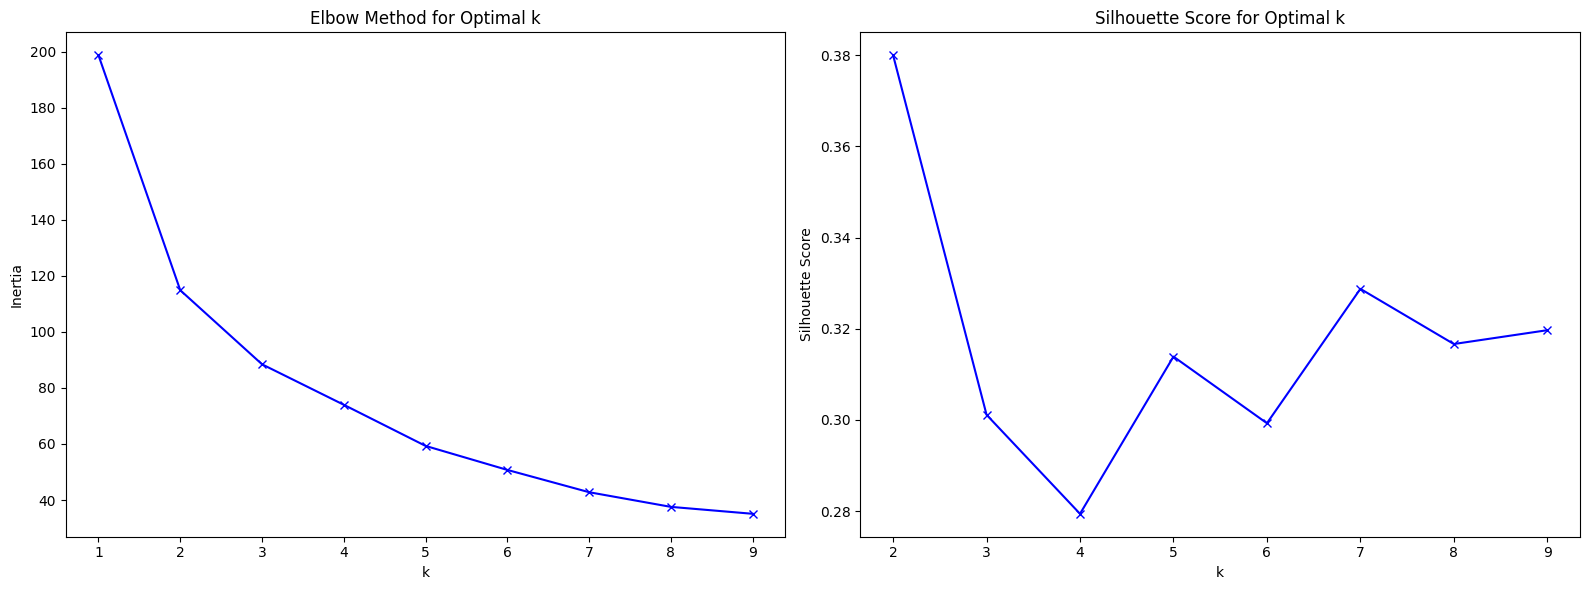

In [179]:
# Find optimal k using elbow method and silhouette score

inertias = []
silhouette_scores = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=144)
    kmeans.fit(vectors)
    inertias.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(vectors, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Inertia
ax1.plot(range(1, 10), inertias, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')

# Plot for Silhouette Score
ax2.plot(range(2, 10), silhouette_scores, 'bx-')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Optimal k')

plt.tight_layout()
plt.show()

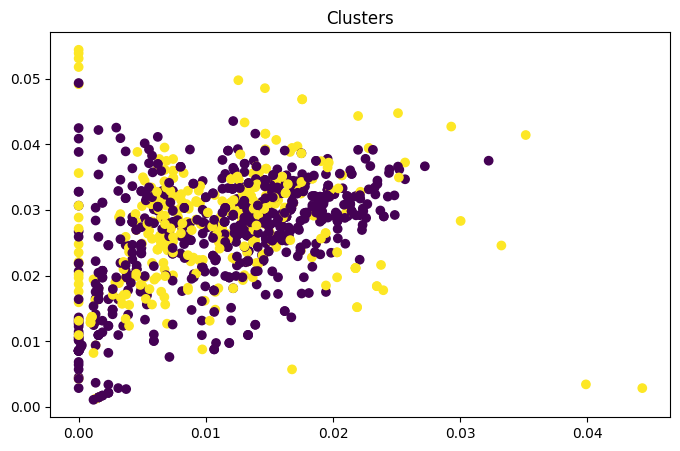

In [180]:
# Choose k=2
kmeans = KMeans(n_clusters=2, random_state=144)
kmeans_labels = kmeans.fit_predict(vectors)

# Add cluster labels to the original dataframe
embedded_data['KMeans_Cluster'] = kmeans_labels

# Plot clusters
plt.figure(figsize=(8, 5))
plt.scatter(x=vectors[:, 0], y=vectors[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('Clusters')
plt.show()

DBSCAN:

In [181]:
# Function to compute silhouette score for DBSCAN with different parameters
def compute_silhouette_score(data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(vectors)
    if len(set(labels)) > 1:
        return silhouette_score(vectors, labels)
    else:
        return -1

# Grid search for eps and min_samples
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = range(2, 10)
best_score = -1
best_params = {'eps': None, 'min_samples': None}

for eps in eps_values:
    for min_samples in min_samples_values:
        score = compute_silhouette_score(vectors, eps, min_samples)
        if score > best_score:
            best_score = score
            best_params['eps'] = eps
            best_params['min_samples'] = min_samples

print(f"Best silhouette score: {best_score}")
print(f"Best parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")


Best silhouette score: 0.7226779467264457
Best parameters: eps=0.4, min_samples=5


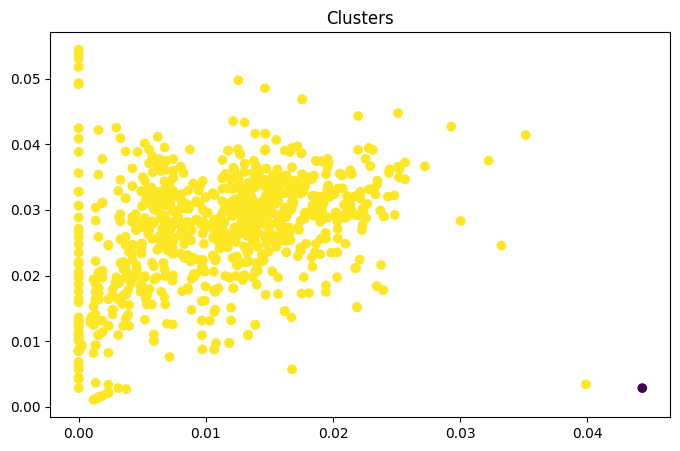

In [182]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
dbscan_labels = dbscan.fit_predict(vectors)

# Add cluster labels to the original dataframe
embedded_data['DBSCAN_Cluster'] = dbscan_labels

# Plot clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(vectors)

plt.figure(figsize=(8, 5))
plt.scatter(x=vectors[:, 0], y=vectors[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('Clusters')
plt.show()

### Encoding of Traces as Graphs

In [87]:
# Convert traces to graphs
def trace_to_graph(trace):
    G = nx.DiGraph()
    if len(trace) > 0:
        for i in range(len(trace) - 1):
            G.add_edge(trace[i], trace[i + 1])
    else:
        G.add_node(trace[0])
    return G

In [183]:
# Map each activity to a  number
activity_to_number = {activity: i for i, activity in enumerate(activities.keys())}
number_to_activity = {i: activity for activity, i in activity_to_number.items()}

# Group traces by unique traces to reduce computation time
unique_traces['trace_numbers'] = unique_traces['trace'].apply(lambda x: [activity_to_number[activity] for activity in x])

# Create directly follows graph for each trace
unique_traces['graph'] = unique_traces['trace_numbers'].apply(trace_to_graph)

# Map traces to sequences of numbers
unique_traces['trace_numbers'] = unique_traces['trace'].apply(lambda x: [activity_to_number[activity] for activity in x])

Note that the graph-output in the following table looks like a path for each trace, but for traces with repeating activities, the graph object reflects this accordingly.

In [185]:
unique_traces

,trace,case_ids,sample_case_id,trace_numbers,graph
0,"(NEW,)","[AAA, AAAD, AAB, AABB, AACE, AAD, AADE, AAGE, ...",AAA,[0],()
1,"(NEW, BILLED)","[EOL, SFKA, TFKA]",EOL,"[0, 4]","(0, 4)"
2,"(NEW, CHANGE DIAGN)","[ANQD, BDNE, BJLE, DOME, ETKE, IBME, PZOE, QJJ...",ANQD,"[0, 7]","(0, 7)"
3,"(NEW, CHANGE DIAGN, CHANGE DIAGN)",[UWC],UWC,"[0, 7, 7]","(0, 7)"
4,"(NEW, CHANGE DIAGN, CHANGE DIAGN, CHANGE DIAGN...","[HAMD, QPF]",HAMD,"[0, 7, 7, 7, 7, 7, 1, 2, 3, 4]","(0, 7, 1, 2, 3, 4)"
...,...,...,...,...,...
1015,"(NEW, RELEASE, BILLED, STORNO, BILLED)",[CEV],CEV,"[0, 2, 4, 8, 4]","(0, 2, 4, 8)"
1016,"(NEW, RELEASE, CHANGE END, FIN, RELEASE, BILLE...",[ZBJA],ZBJA,"[0, 2, 12, 1, 2, 4, 8, 9, 13, 4]","(0, 2, 12, 1, 4, 8, 9, 13)"
1017,"(NEW, RELEASE, CODE NOK, MANUAL, MANUAL, BILLED)",[QGIA],QGIA,"[0, 2, 10, 13, 13, 4]","(0, 2, 10, 13, 4)"
1018,"(NEW, SET STATUS)","[BTVB, DZEB, EQN, FPZA, IAWB, LOOD, LVQ, MZRA,...",BTVB,"[0, 11]","(0, 11)"


In [187]:
# Find traces that have more than 2 and less than 15 activities
unique_traces = unique_traces[unique_traces['trace'].apply(len) > 2].reset_index(drop=True)
unique_traces = unique_traces[unique_traces['trace'].apply(len) < 15].reset_index(drop=True)

# Sample 100 traces for performance reasons
traces_sampled = unique_traces.sample(100, random_state=144).reset_index(drop=True)


In [188]:
# Calculate graph-edit distance between all traces
graph_edit_distances = np.zeros((len(traces_sampled), len(traces_sampled)))

In [189]:
# Calculate graph-edit distance between all traces
graph_edit_distances = np.zeros((len(traces_sampled), len(traces_sampled)))
for i in tqdm(range(len(traces_sampled))):
    for j in tqdm(range(i + 1, len(traces_sampled)), leave=False):
        graph_edit_distances[i, j] = nx.graph_edit_distance(traces_sampled['graph'].iloc[i], traces_sampled['graph'].iloc[j])

graph_edit_distances += graph_edit_distances.T

100%|██████████| 100/100 [18:12<00:00, 10.93s/it]


### Distance Based on Graph Hashing

### Postprocessing:

Create sublogs based on the clustering results

In [26]:
def create_cluster_logs(original_log, cluster_assignments):
    cluster_logs = {}
    for cluster_id, cases in enumerate(cluster_assignments.values()):
        new_log = pm4py.objects.log.obj.EventLog()
        for trace in original_log:
            if trace.attributes['concept:name'] in cases:
                new_log.append(trace)
        cluster_logs[cluster_id] = new_log
    return cluster_logs

In [27]:
# Grouping cases by their KMeans cluster labels
kmeans_clusters = {}
for label in embedded_data['KMeans_Cluster'].unique():
    kmeans_clusters[label] = embedded_data[embedded_data['KMeans_Cluster'] == label]['case'].tolist()

# Grouping cases by their DBSCAN cluster labels
dbscan_clusters = {}
for label in embedded_data['DBSCAN_Cluster'].unique():
    dbscan_clusters[label] = embedded_data[embedded_data['DBSCAN_Cluster'] == label]['case'].tolist()
# Filter out outliers but keep them for further analysis
filtered_dbscan_clusters = {key: value for key, value in dbscan_clusters.items() if len(value) >= 3}
outliers = {key: value for key, value in dbscan_clusters.items() if len(value) < 3}

cluster_logs_kmeans = create_cluster_logs(event_log, kmeans_clusters)
cluster_logs_dbscan = create_cluster_logs(event_log, dbscan_clusters)

### Interpretation and Visualization:

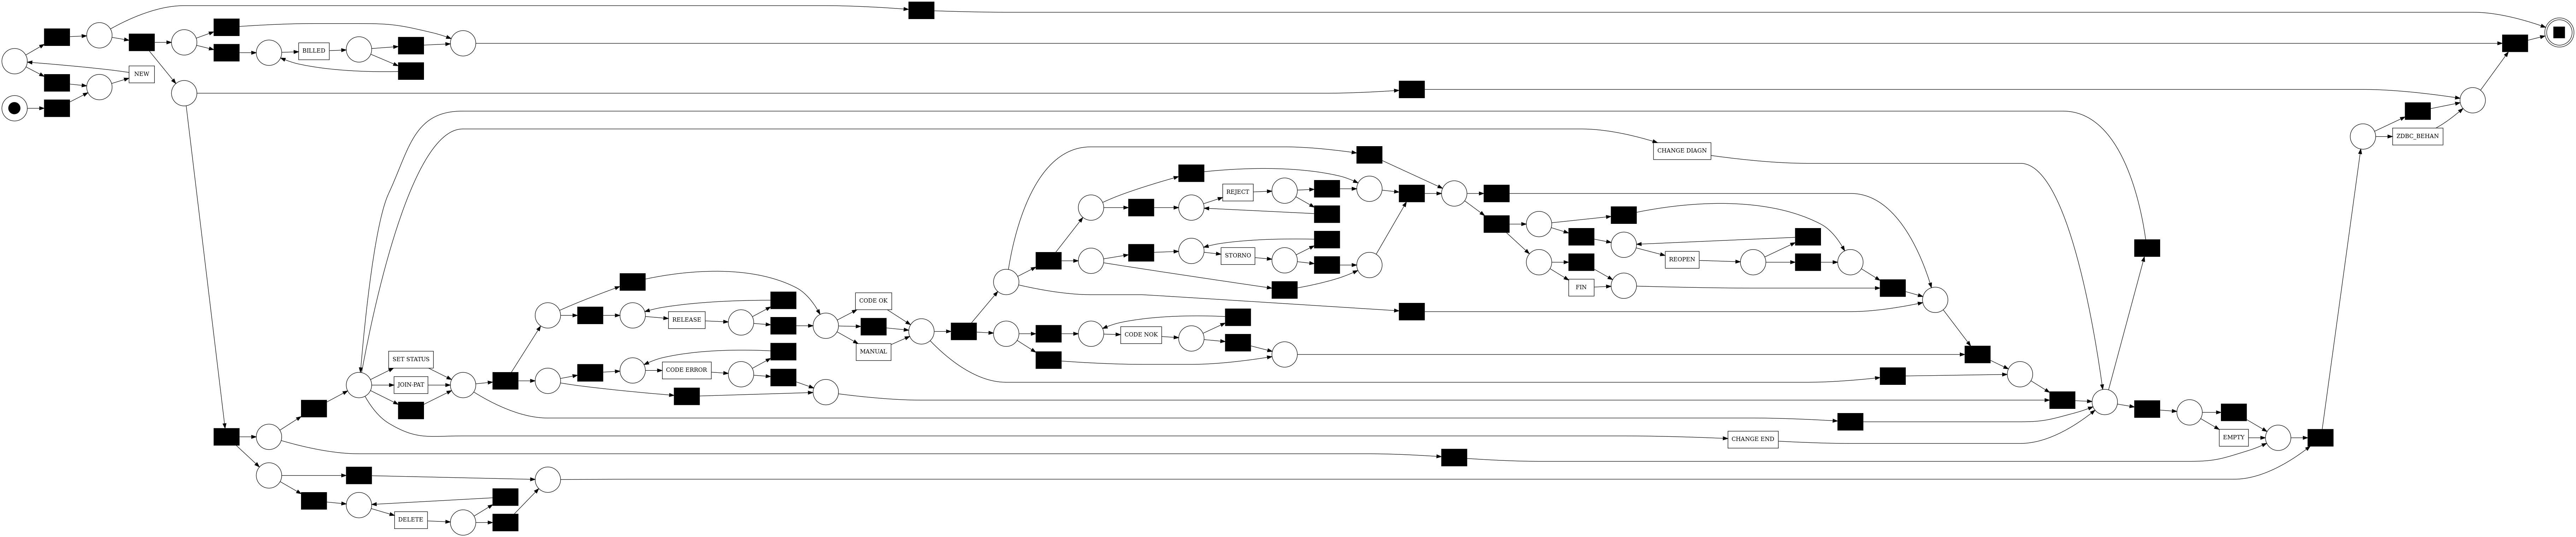

In [28]:
# Initial process discovery, inductive miner
net, start, end = pm4py.discover_petri_net_inductive(event_log)
pm4py.view_petri_net(net, start, end)

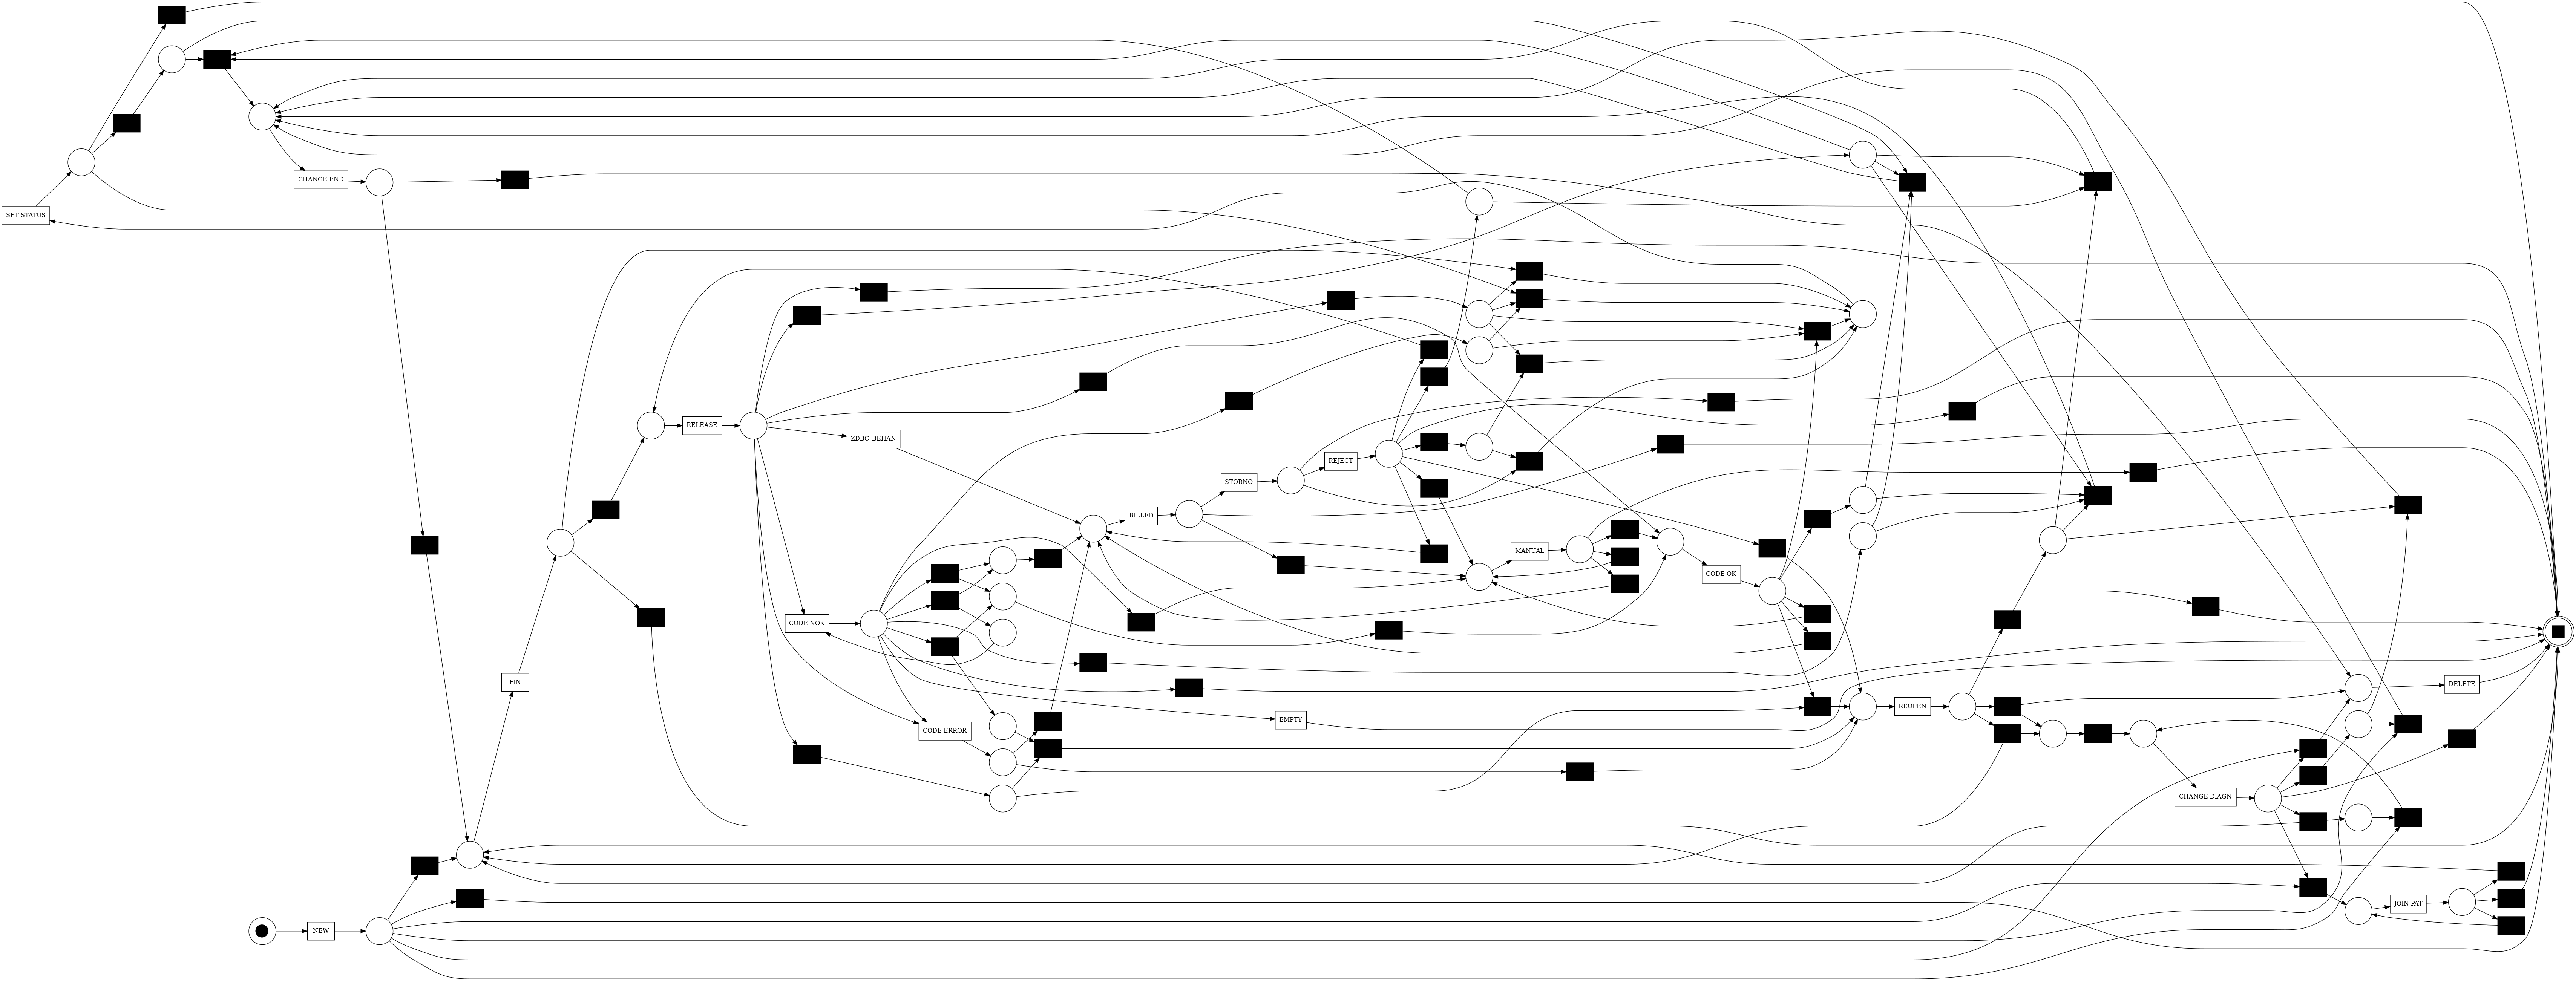

In [29]:
# Initial process discovery, heuristics miner
net, start, end = pm4py.discover_petri_net_heuristics(event_log)
pm4py.view_petri_net(net, start, end)

Cluster including 3220 many cases


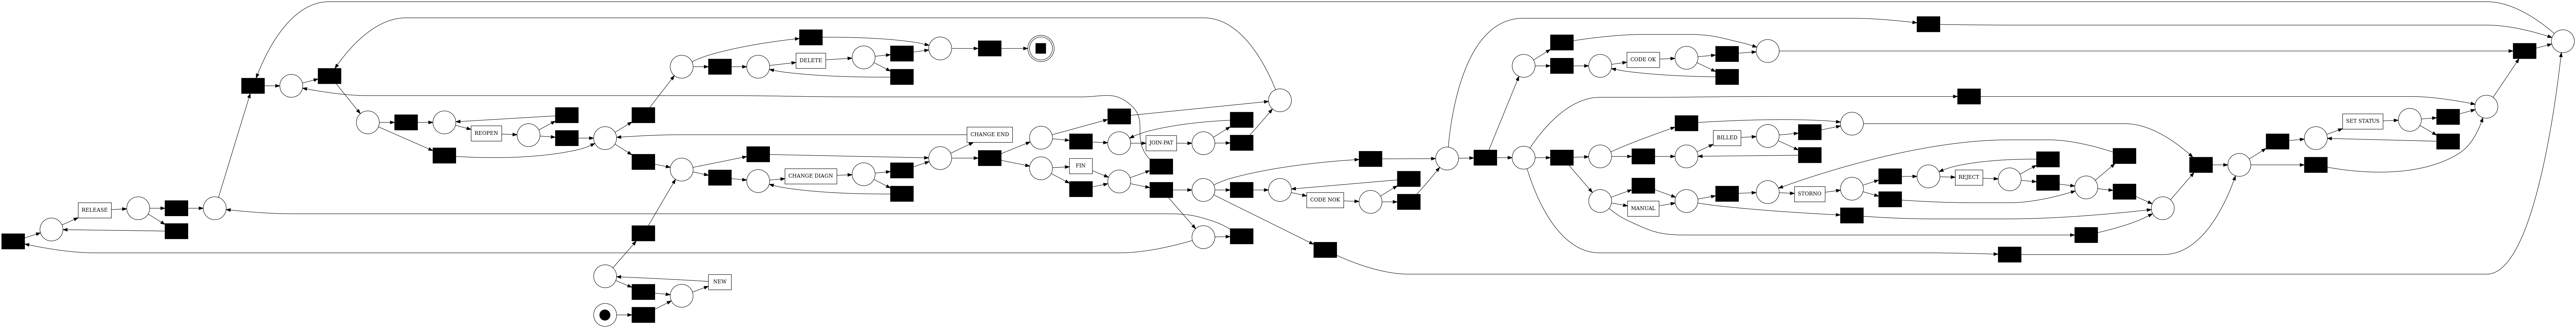

Cluster including 776 many cases


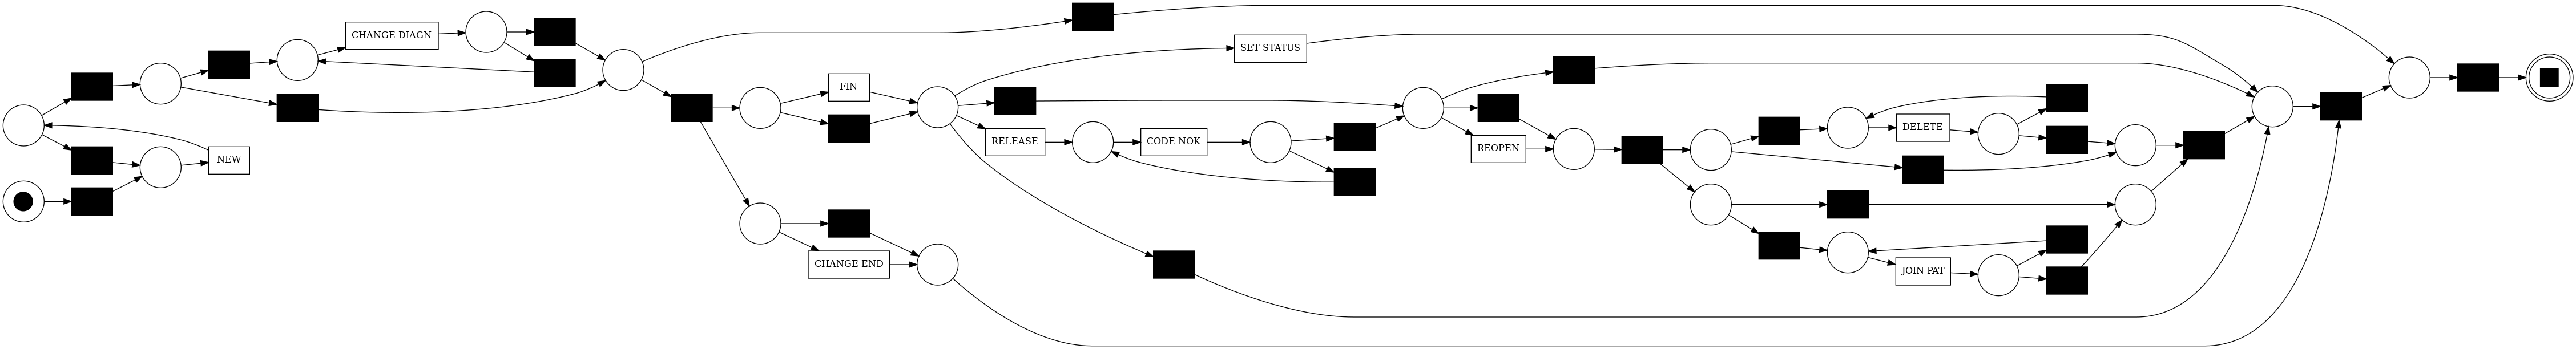

Cluster including 410 many cases


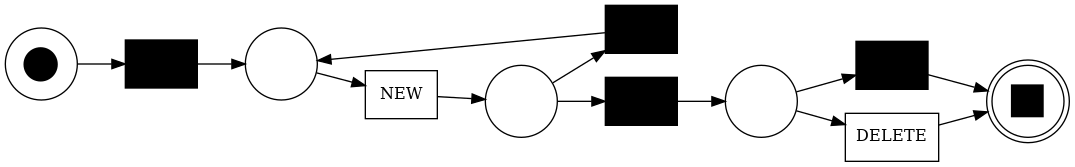

In [36]:
# Process discovery for each cluster produced by KMeans, inductive miner
for cluster_id, cluster_log in cluster_logs_kmeans.items():
    net, start, end = pm4py.discover_petri_net_inductive(cluster_log)
    print(f"Cluster including {len(kmeans_clusters[cluster_id])} many cases")
    pm4py.view_petri_net(net, start, end)